### 練習問題2.45
right-splitとup-splitは、汎⽤の分割演算の具体例として表現できる。  
以下の式を評価したとき、  

    (define right-split (split beside below))
    (define up-split (split below beside))

すでに定義したのものと同じふるまいを持つ⼿続き  
right-splitとup-splitが得られるように、   
split⼿続きを定義せよ。

In [1]:
;
(define (frame-coord-map frame)
  (lambda (v)
    (add-vect
     (origin-frame frame)
     (add-vect (scale-vect (xcor-vect v)
                           (edge1-frame frame))
               (scale-vect (ycor-vect v)
                           (edge2-frame frame))))))

; ベクトルコンストラクタ・セレクタ
(define (make-vect x y) (cons x y))
(define (xcor-vect v)(car v))
(define (ycor-vect v)(cdr v))

; ベクトル演算
(define (add-vect v1 v2)
  (make-vect (+ (xcor-vect v1)
                (xcor-vect v2))
             (+ (ycor-vect v1)
                (ycor-vect v2))))
(define (sub-vect v1 v2)
  (make-vect (- (xcor-vect v1)
                (xcor-vect v2))
             (- (ycor-vect v1)
                (ycor-vect v2))))

; ベクトル演算
(define (scale-vect s v)
  (make-vect (* s (xcor-vect v))
             (* s (ycor-vect v))))

; フレームコンストラクタ・セレクタ
(define (make-frame origin edge1 edge2)(list origin edge1 edge2))
(define (origin-frame frame)(car frame))
(define (edge1-frame frame)(cadr frame))
(define (edge2-frame frame)(caddr frame))

; 線分コンストラクタ・セレクタ
(define (make-segment v1 v2)(cons v1 v2))
(define (start-segment seg)(car seg))
(define (end-segment seg)(cdr seg))

; ペインタ
(define (segments->painter segment-list)
  (lambda (frame)
    (for-each
     (lambda (segment)
       (draw-line
        ((frame-coord-map frame) (start-segment segment))
        ((frame-coord-map frame) (end-segment segment))))
     segment-list)))

;
(define (make-segment-list vect-list)
  (map
   (lambda (x)
     (make-segment (car x) (cadr x)))
   vect-list))

; waveペインタ
; https://gist.github.com/tkmr/28498
; を参考にしました。
(define wave
  (lambda (frame)
    ((segments->painter
      (list (make-segment (make-vect 0.000 0.645) (make-vect 0.154 0.411))
            (make-segment (make-vect 0.154 0.411) (make-vect 0.302 0.588))
            (make-segment (make-vect 0.302 0.588) (make-vect 0.354 0.497))
            (make-segment (make-vect 0.354 0.497) (make-vect 0.245 0.000))
            (make-segment (make-vect 0.419 0.000) (make-vect 0.497 0.171))
            (make-segment (make-vect 0.497 0.171) (make-vect 0.575 0.000))
            (make-segment (make-vect 0.748 0.000) (make-vect 0.605 0.462))
            (make-segment (make-vect 0.605 0.462) (make-vect 1.000 0.142))
            (make-segment (make-vect 1.000 0.354) (make-vect 0.748 0.657))
            (make-segment (make-vect 0.748 0.657) (make-vect 0.582 0.657))
            (make-segment (make-vect 0.582 0.657) (make-vect 0.640 0.857))
            (make-segment (make-vect 0.640 0.857) (make-vect 0.575 1.000))
            (make-segment (make-vect 0.419 1.000) (make-vect 0.354 0.857))
            (make-segment (make-vect 0.354 0.857) (make-vect 0.411 0.657))
            (make-segment (make-vect 0.411 0.657) (make-vect 0.285 0.657))
            (make-segment (make-vect 0.285 0.657) (make-vect 0.154 0.605))
            (make-segment (make-vect 0.154 0.605) (make-vect 0.000 0.857)))) frame)))


; ペインタ変換と組み合わせ
(define (transform-painter painter origin corner1 corner2)
  (lambda (frame)
    (let ((m (frame-coord-map frame)))
      (let ((new-origin (m origin)))
        (painter
         (make-frame new-origin
                     (sub-vect (m corner1) new-origin)
                     (sub-vect (m corner2) new-origin)))))))

(define (flip-vert painter)
  (transform-painter painter
                     (make-vect 0.0 1.0)
                     (make-vect 1.0 1.0)
                     (make-vect 0.0 0.0)))

(define (rotate90 painter)
  (transform-painter painter
                     (make-vect 1.0 0.0)
                     (make-vect 1.0 1.0)
                     (make-vect 0.0 1.0)))

(define (beside painter1 painter2)
  (let ((split-point (make-vect 0.5 0.0)))
    (let ((paint-left
           (transform-painter painter1
                              (make-vect 0.0 0.0)
                              split-point
                              (make-vect 0.0 1.0)))
          (paint-right
           (transform-painter painter2
                              split-point
                              (make-vect 1.0 0.0)
                              (make-vect 0.5 1.0))))
      (lambda (frame)
        (paint-left frame)
        (paint-right frame)))))

(define (below painter1 painter2)
  (let ((split-point (make-vect 0.0 0.5)))
    (let ((paint-below
           (transform-painter painter1
                              (make-vect 0.0 0.0)
                              (make-vect 1.0 0.0)
                              split-point))
          (paint-above
           (transform-painter painter2
                              split-point
                              (make-vect 1.0 0.5)
                              (make-vect 0.0 1.0))))
      (lambda (frame)
        (paint-below frame)
        (paint-above frame)))))

; pythonのcalystoを利用した線画用の描画モジュール
(import-as "picseg" 'pic)

; 線分の描画
(define (draw-line v1 v2)
  (let ((start-x (xcor-vect v1))
        (start-y (ycor-vect v1))
        (end-x (xcor-vect v2))
        (end-y (ycor-vect v2)))
    (pic.draw_line start-x start-y end-x end-y)
    )
  )

; ペインタの動作確認
(define (disp painter)
  (let ((frame0 (make-frame
                            (make-vect 0 0)
                            (make-vect 1 0)
                            (make-vect 0 1))))
    (pic.clear)
    (painter frame0)
    (pic.update)
    )
  )

In [2]:
; 回答
; splitの実装
(define (split op1 op2)
  (lambda (painter n) ; lambdaで実装できた！
    (if (= n 0) painter
      (let ((smaller ((split op1 op2) painter (- n 1))))
        (op1 painter (op2 smaller smaller))
        )
      )
    )
  )

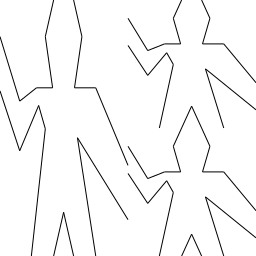

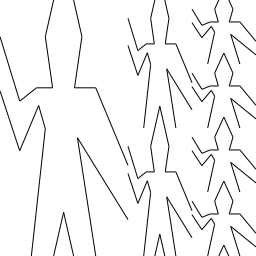

In [3]:
(define right-split (split beside below))

; right-splitの動作確認
(disp (right-split wave 1))
(disp (right-split wave 2))

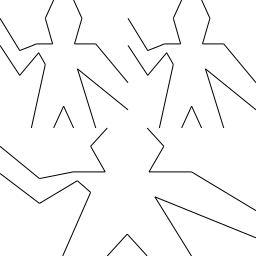

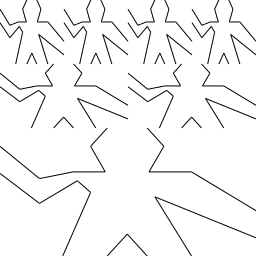

In [4]:
(define up-split (split below beside))

; up-splitの動作確認
(disp (up-split wave 1))
(disp (up-split wave 2))